In [26]:
import collections
import qiskit
import qiskit_aer
import time

import numpy
import pandas

from matplotlib import pyplot as plt
%matplotlib inline

## Quantum Circut (1)

In [2]:
def get_circuit1():
    """Create the first circuit."""
    circ = qiskit.QuantumCircuit(3, 0, name='Circ1', global_phase=0)

    # Add Hadamard gates
    circ.h(0)
    circ.h(1)
    circ.h(2)
    
    # Add a custom rotation
    circ.ry(1.8, 0)
    circ.ry(1.3, 1)
    circ.rz(0.5, 2)
    
    # Perform a controlled-X (CNOT) gate on qubit 1, controlled by qubit 0
    circ.cx(0, 1)
    circ.cx(1, 2)
    circ.cx(0, 2)

    return circ

In [3]:
# Visualise
circ1 = get_circuit1()
circ1.draw(style='iqp')

┌───┐┌─────────┐               
q_0: ┤ H ├┤ Ry(1.8) ├──■─────────■──
     ├───┤├─────────┤┌─┴─┐       │  
q_1: ┤ H ├┤ Ry(1.3) ├┤ X ├──■────┼──
     ├───┤├─────────┤└───┘┌─┴─┐┌─┴─┐
q_2: ┤ H ├┤ Rz(0.5) ├─────┤ X ├┤ X ├
     └───┘└─────────┘     └───┘└───┘

In [4]:
def statevector_simulation(circuit, base='zzz'):
    """Plot the bloch multivector."""
    circ = circuit.copy()
    
    for i, b in enumerate(base):
        if b == 'y':
            circ.sdg(i)
            circ.h(i)
        elif b == 'x':
            circ.h(i)
        elif b == 'z':
            pass
        else:
            raise KeyError

    backend = qiskit_aer.Aer.get_backend('statevector_simulator')

    job = backend.run(circ)
    result = job.result()

    return result

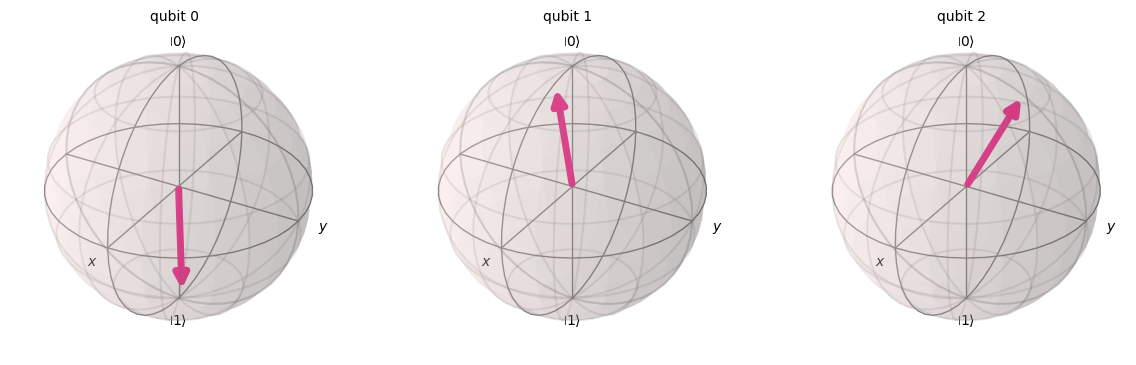

In [5]:
# plot the bloch multivector
result1 = statevector_simulation(circ1, base='zzx')
psi1  = result1.get_statevector(circ1)
qiskit.visualization.plot_bloch_multivector(psi1)

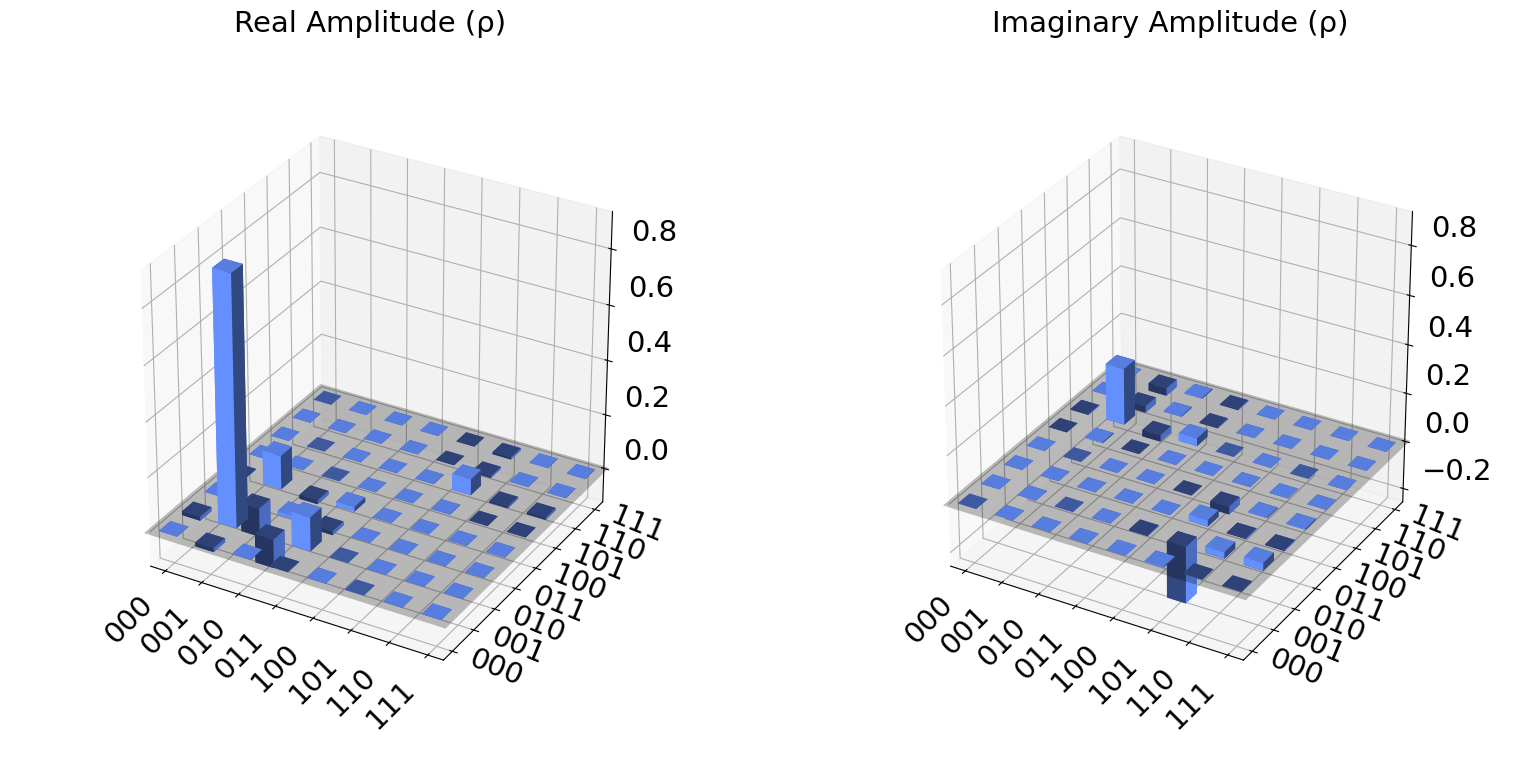

In [6]:
outputstate1 = result1.get_statevector(circ1, decimals=3)
qiskit.visualization.plot_state_city(outputstate1)

## Quantum Circuit (2)

In [7]:
def get_circuit2():
    """Create the first circuit."""
    circ = qiskit.QuantumCircuit(3, 0, name='Circ1', global_phase=0)

    # Add Hadamard gates
    circ.h(0)
    circ.h(1)
    circ.h(2)
    
    # Add a custom rotation
    circ.rz(1.8, 0)
    circ.rz(2.3, 1)
    circ.ry(0.5, 2)
    
    # Perform a controlled-X (CNOT) gate on qubit 1, controlled by qubit 0
    circ.cx(0, 1)
    circ.cx(1, 2)
    circ.cx(0, 2)

    return circ

In [8]:
# Visualise
circ2 = get_circuit2()
circ2.draw(style='iqp')

┌───┐┌─────────┐               
q_0: ┤ H ├┤ Rz(1.8) ├──■─────────■──
     ├───┤├─────────┤┌─┴─┐       │  
q_1: ┤ H ├┤ Rz(2.3) ├┤ X ├──■────┼──
     ├───┤├─────────┤└───┘┌─┴─┐┌─┴─┐
q_2: ┤ H ├┤ Ry(0.5) ├─────┤ X ├┤ X ├
     └───┘└─────────┘     └───┘└───┘

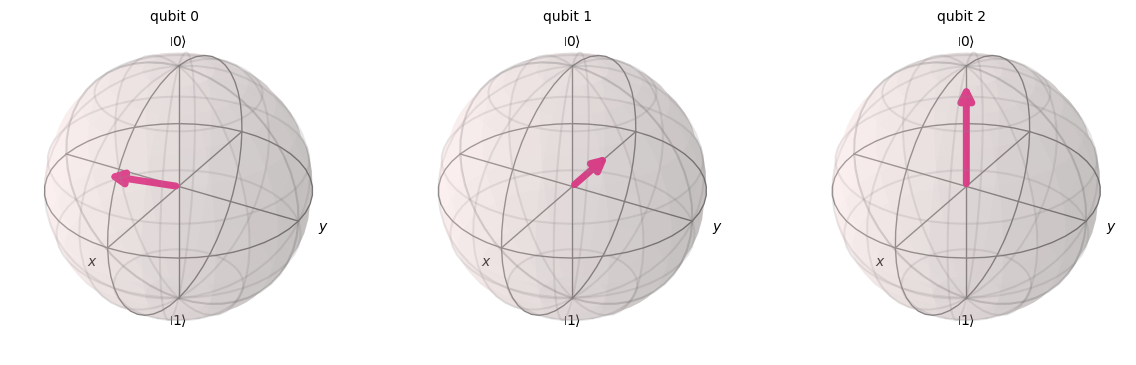

In [9]:
# plot the bloch multivector
result2 = statevector_simulation(circ2, base='zzx')
psi2  = result2.get_statevector(circ2)
qiskit.visualization.plot_bloch_multivector(psi2)

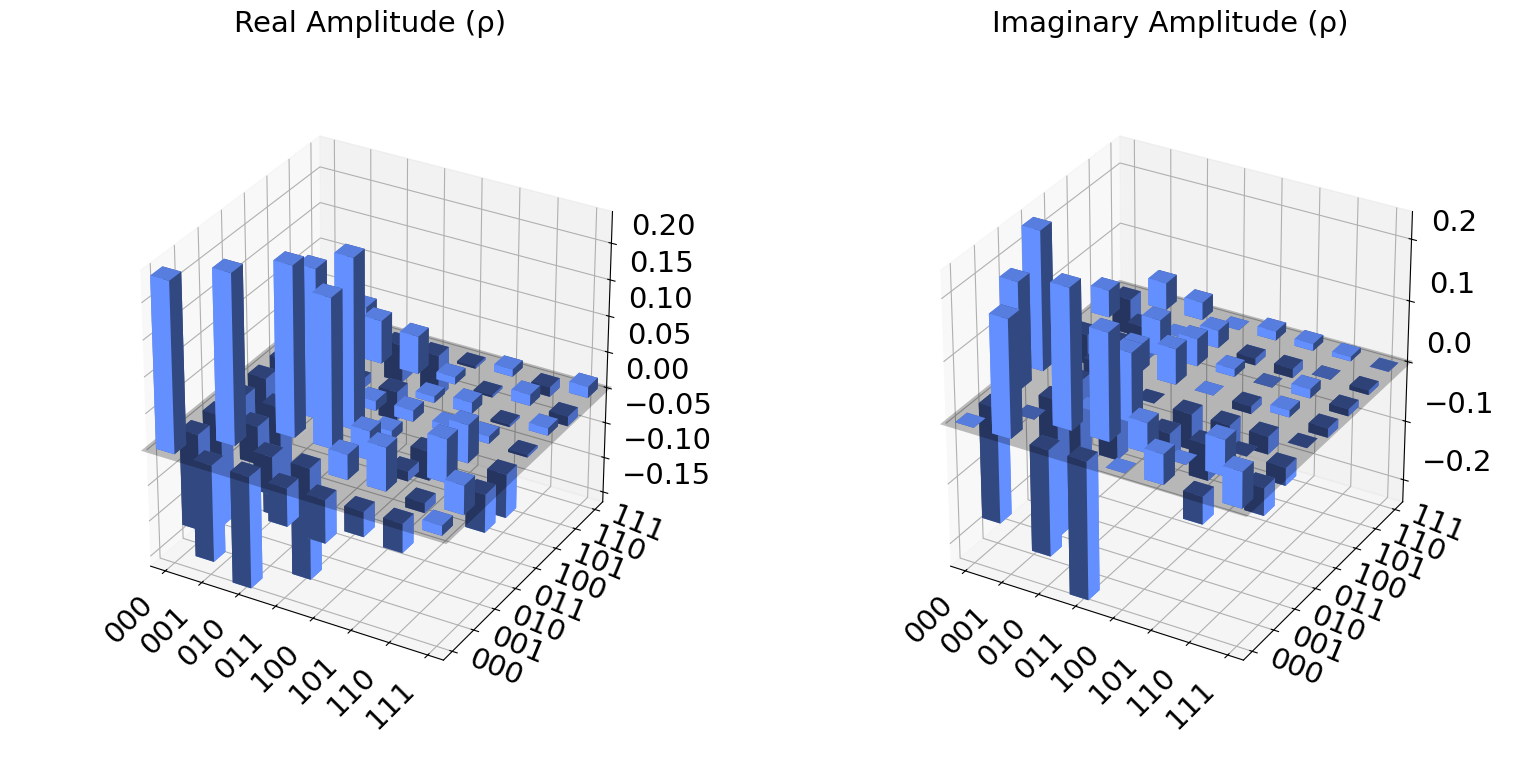

In [10]:
outputstate2 = result2.get_statevector(circ2, decimals=3)
qiskit.visualization.plot_state_city(outputstate2)

## Measurements

In [11]:
def measure(circuit, shots=1, base='zzz'):
    """Make measurements."""
    circ = circuit.copy()

    # add rotations to measure in a given base
    for i, b in enumerate(base):
        if b == 'y':
            circ.sdg(i)
            circ.h(i)
        elif b == 'x':
            circ.h(i)
        elif b == 'z':
            pass
        else:
            raise KeyError

    # map the quantum measurement to the classical bits
    meas = qiskit.QuantumCircuit(3, 3)
    meas.barrier(range(3))
    meas.measure(range(3), range(3))
    
    # The Qiskit circuit object supports composition using
    # the compose method.
    circ.add_register(meas.cregs[0])
    qc = circ.compose(meas)

    # Use Aer's qasm_simulator
    backend_sim = qiskit_aer.Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    job_sim = backend_sim.run(qiskit.transpile(qc, backend_sim), shots=shots)

    counts = job_sim.result().get_counts(circ)
    counts = {tuple([int(i) for i in k]): v for k, v in counts.items()}    
    results = [k for k, v in counts.items() for _ in range(v)]
    
    return results

In [12]:
measure(circ1, shots=10, base='zzx')

[(1, 0, 1),
 (1, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1)]

In [13]:
measure(circ2, shots=10, base='zzx')

[(0, 1, 1),
 (0, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 1, 0),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1)]

## Agreement

In [14]:
result = []
for base in numpy.random.choice(['x', 'y', 'z'], size=3*10**3).reshape(-1, 3):
    base = ''.join(base)
    m1 = measure(circ1, shots=1, base=base)[0]
    m2 = measure(circ2, shots=1, base=base)[0]
    
    m1b = measure(circ1, shots=1, base=base)[0]
    m2b = measure(circ2, shots=1, base=base)[0]
    

    result.append({'base': base, 'c1': m1, 'c2': m2, 'c1bis': m1b, 'c2bis': m2b})

df = pandas.DataFrame(result)
df

,base,c1,c2,c1bis,c2bis
0,zxz,"(0, 1, 1)","(0, 0, 0)","(0, 0, 1)","(1, 1, 0)"
1,xxx,"(1, 0, 1)","(1, 1, 1)","(0, 0, 0)","(0, 0, 1)"
2,yxy,"(1, 1, 1)","(0, 1, 1)","(1, 1, 1)","(1, 0, 0)"
3,yxx,"(0, 1, 1)","(0, 1, 1)","(0, 0, 1)","(0, 1, 1)"
4,zzy,"(1, 0, 1)","(1, 0, 0)","(0, 0, 1)","(1, 0, 1)"
...,...,...,...,...,...
995,xxz,"(1, 0, 1)","(1, 1, 0)","(0, 1, 1)","(0, 1, 1)"
996,yzy,"(0, 0, 0)","(0, 1, 1)","(1, 0, 0)","(1, 1, 0)"
997,yxz,"(1, 0, 1)","(0, 1, 1)","(1, 0, 0)","(0, 0, 0)"
998,yxy,"(1, 0, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)"


## Sanity Check

In [15]:
def measure_z(circuit, shots=1):
    """Make measurements."""
    circ = circuit.copy()

    # map the quantum measurement to the classical bits
    meas = qiskit.QuantumCircuit(3, 3)
    meas.barrier(range(3))
    meas.measure(range(3), range(3))
    
    # The Qiskit circuit object supports composition using
    # the compose method.
    circ.add_register(meas.cregs[0])
    qc = circ.compose(meas)

    # Use Aer's qasm_simulator
    backend_sim = qiskit_aer.Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    job_sim = backend_sim.run(qiskit.transpile(qc, backend_sim), shots=shots)

    counts = job_sim.result().get_counts(circ)
    
    return counts

In [16]:
circ1 = get_circuit1()
measure_z(circ1, shots=1000)

{'010': 12, '100': 1, '110': 7, '011': 11, '111': 9, '101': 504, '001': 456}

In [17]:
collections.Counter(df[df.base == 'zzz']['c1'])

Counter({(1, 0, 1): 23, (0, 0, 1): 12})

## Agreement

In [18]:
# check the same circuit
res = []
for i, line in df.iterrows():
    c1 = line['c1']
    c2 = line['c1bis']

    for a, b in zip(c1, c2):
        res.append(a == b)        

numpy.array(res, dtype='int32').mean()

0.654

In [19]:
# check the same circuit
res = []
for i, line in df.iterrows():
    c1 = line['c2']
    c2 = line['c2bis']

    for a, b in zip(c1, c2):
        res.append(a == b)        

numpy.array(res, dtype='int32').mean()

0.5806666666666667

In [20]:
# check different circuit
res = []
for i, line in df.iterrows():
    c1 = line['c1']
    c2 = line['c2']

    for a, b in zip(c1, c2):
        res.append(a == b)        

numpy.array(res, dtype='int32').mean()

0.5366666666666666

In [21]:
aggreement = lambda d: numpy.array([
    [a==b for a, b, in zip(line['c1'], line['c2'])] for _, line in d.iterrows()]).mean()

aggreement(df)

0.5366666666666666

## Plot

Text(0, 0.5, 'agreement')

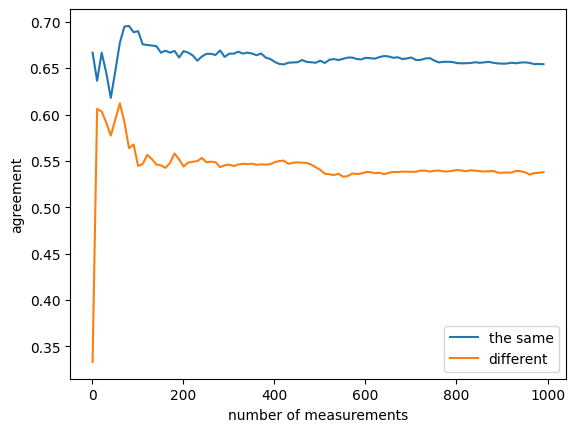

In [22]:
# the same
aggreement = lambda d: numpy.array([
    [a==b for a, b, in zip(line['c1'], line['c1bis'])] for _, line in d.iterrows()]).mean()

x, y = [], []
for i in range(1, 1000, 10):
    x.append(i)
    y.append(aggreement(df.iloc[:i]))

plt.plot(x, y, label='the same')

# different
aggreement = lambda d: numpy.array([
    [a==b for a, b, in zip(line['c1'], line['c2'])] for _, line in d.iterrows()]).mean()

x, y = [], []
for i in range(1, 1000, 10):
    x.append(i)
    y.append(aggreement(df.iloc[:i]))

plt.plot(x, y, label='different')

plt.legend()
plt.xlabel('number of measurements')
plt.ylabel('agreement')

Text(0, 0.5, 'agreement')

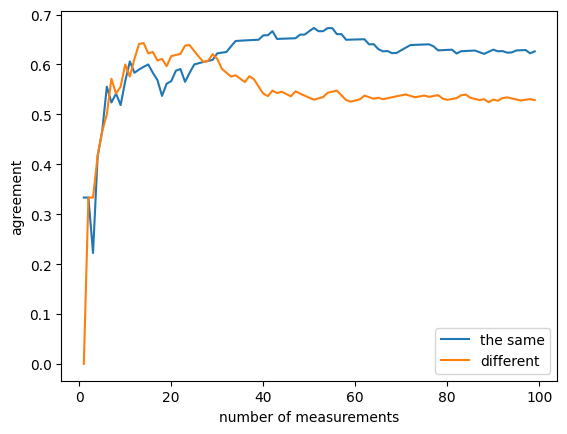

In [25]:
# the same
aggreement = lambda d: numpy.array([
    [a==b for a, b, in zip(line['c2'], line['c2bis'])] for _, line in d.iterrows()]).mean()

x, y = [], []
for i in range(1, 100, 1):
    x.append(i)
    y.append(aggreement(df.iloc[:i]))

plt.plot(x, y, label='the same')

# different
aggreement = lambda d: numpy.array([
    [a==b for a, b, in zip(line['c1bis'], line['c2bis'])] for _, line in d.iterrows()]).mean()

x, y = [], []
for i in range(1, 100, 1):
    x.append(i)
    y.append(aggreement(df.iloc[:i]))

plt.plot(x, y, label='different')

plt.legend()
plt.xlabel('number of measurements')
plt.ylabel('agreement')